In [2]:
import MDAnalysis as mda
import matplotlib.pyplot as plt
import math
import numpy as np

d:\all_programming\MSD\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
graphite_water_psf = r'D:\all_programming\MSD\data_files\unwrapped\graphite_water.psf'
graphite_trajectory_dcd = r'D:\all_programming\MSD\data_files\unwrapped\output_per_20ps.dcd'

global_uni = mda.Universe(graphite_water_psf,graphite_trajectory_dcd)
Oxg_uni = global_uni.select_atoms('resname SPCE and name OW')
# Importing data

d:\all_programming\MSD\.venv\Lib\site-packages\MDAnalysis\coordinates\DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [4]:
z_maxs = []

for frame in range(len(global_uni.trajectory)):
    global_uni.trajectory[frame]
    z_vals = []
    for atom in Oxg_uni.positions:
        z_vals.append(atom[2])
    z_maxs.append(max(z_vals))
# Appends the max z_val in each frame to z_maxs
# Generally lower than 65 until some weird extremes occur which we ignore

upper_z_bound = 65
partition_count = 4
z_partitions = []

for i in range(partition_count):
    z_partitions.append(upper_z_bound * (i / partition_count))
z_partitions.append(upper_z_bound)
# Creates partition list with upper and lower bound included

In [5]:
def calculate_msd(position_dict):

    part_location = position_dict['location']
    x_vals = np.array(position_dict['x_vals'])
    y_vals = np.array(position_dict['y_vals'])
    z_vals = np.array(position_dict['z_vals'])
    # Import needed data

    # Number of time points
    num_points = len(x_vals)
    
    # Initialize MSD array
    msd = np.zeros(num_points)
    
    # Calculate displacements and MSD
    for dt in range(1, num_points):
        displacements = []
        for t in range(num_points - dt):
            dx = x_vals[t + dt] - x_vals[t]
            dy = y_vals[t + dt] - y_vals[t]
            dz = z_vals[t + dt] - z_vals[t]
            displacement_squared = dx**2 + dy**2 + dz**2
            displacements.append(displacement_squared)
        
        msd[dt] = np.mean(displacements)
    
    return [msd, part_location]


In [6]:
atom_initial_part_list = []

for atom_num in range(len(Oxg_uni)):
    global_uni.trajectory[0]
    Oxg_positions = Oxg_uni.positions
    current_z = Oxg_positions[atom_num][2]
    
    for i in range(len(z_partitions)):
        if current_z < z_partitions[i]:
            atom_initial_part_list.append(i)
            break
# Determining which part atoms are initially in

In [7]:
atom_dict = {}

for atom_num in range(len(Oxg_uni)):
    atom_dict[atom_num] = {'x_vals':[],'y_vals':[],'z_vals':[]}
    
    try:
        for frame in range(len(global_uni.trajectory)):
            global_uni.trajectory[frame]
            Oxg_positions = Oxg_uni.positions
            current_z = Oxg_positions[atom_num][2]

            for current_part in range(len(z_partitions)):
                if current_z < z_partitions[current_part]:
                    atom_dict[atom_num]['location'] = current_part
                    break

            if current_part == atom_initial_part_list[atom_num]:
                atom_dict[atom_num]['x_vals'].append(Oxg_positions[atom_num][0])
                atom_dict[atom_num]['y_vals'].append(Oxg_positions[atom_num][1])
                atom_dict[atom_num]['z_vals'].append(current_z)
            else:
                raise NotImplementedError
    except NotImplementedError:
        continue

msd_dict = {}
for atom_num in range(len(atom_dict.keys())):
    msd_dict[atom_num] = calculate_msd(atom_dict[atom_num])

In [8]:
for key in atom_dict.keys():
    print(f'{key}: {atom_dict[key]}')

0: {'x_vals': [7.9090557, 8.166417], 'y_vals': [8.227928, 7.546532], 'z_vals': [53.621944, 50.768017], 'location': 3}
1: {'x_vals': [-9.072669, -9.216741], 'y_vals': [7.9065566, 10.902164], 'z_vals': [18.868238, 17.666195], 'location': 1}
2: {'x_vals': [-3.9050388, -6.2969584, -5.901826, -3.8429813, -7.730419, -7.621582, -5.048256, -5.3556285, -4.1351824, -6.1257305, -3.7211914], 'y_vals': [-2.7176325, -4.8826284, -7.689549, -4.02997, -2.7344007, -6.066927, -3.5743225, -3.05944, -6.1643763, -1.5877202, -2.7714913], 'z_vals': [39.817158, 36.390377, 36.991497, 40.206238, 38.465614, 41.226715, 36.834614, 37.382965, 36.360073, 32.799805, 33.11639], 'location': 2}
3: {'x_vals': [-5.207735, -6.381581, -2.5148284, -3.7189386, 0.30855414, 0.8471089, 6.7860923, 6.3211327, 3.706548, 9.26198, 9.094729, 6.8184752, 4.5923076, 6.177988, 2.867433, 5.2285624, 1.3348881, 0.7328172, 1.6025448, 0.509821, 2.390252, 2.0085478, 3.6245656], 'y_vals': [0.025348434, 2.4215393, 3.1064978, 5.2937517, 8.475458, 8

In [9]:
for key in msd_dict.keys():
    print(f'{key}: {msd_dict[key]}')

0: [array([0.        , 8.67543823]), 3]
1: [array([ 0.        , 10.43933168]), 1]
2: [array([ 0.        , 18.69044643, 22.30996668, 16.81509123, 30.08075721,
       33.2751235 , 26.53958395, 30.29516961, 30.54043359, 38.63094153,
       44.93698596]), 2]
3: [array([  0.        ,  34.94576473,  47.16170447,  56.69380956,
        69.27850286,  84.40881544, 106.82011209, 113.48640279,
       122.90223722, 138.00338876, 143.75036394, 131.1092411 ,
       131.95646698, 115.42700255, 134.56633024, 144.60158159,
       140.02289916, 142.00607864, 149.41520567, 233.199161  ,
       269.11886228, 273.60254624, 415.74021298]), 3]
4: [array([  0.        ,  28.07912346,  67.35866135, 106.99245828,
       151.96217255, 205.67614083, 267.38596075, 328.77395547,
       375.02383396, 417.86701856, 463.56352363, 500.4625936 ,
       517.11798405, 535.58560601, 531.60775374, 499.59056062,
       428.13796282, 397.60722098, 346.65774957, 323.61071091,
       354.02685652, 304.93059335, 411.04227636]), 2]

In [10]:
for key in msd_dict.keys():
    print(f'{key}: {len(msd_dict[key][0])}')

0: 2
1: 2
2: 11
3: 23
4: 23
5: 2
6: 18
7: 7
8: 9
9: 13
10: 7
11: 2
12: 14
13: 5
14: 13
15: 5
16: 46
17: 14
18: 11
19: 13
20: 41
21: 13
22: 1
23: 4
24: 8
25: 7
26: 2
27: 19
28: 15
29: 4
30: 2
31: 1
32: 1
33: 15
34: 64
35: 17
36: 17
37: 27
38: 5
39: 12
40: 27
41: 3
42: 85
43: 16
44: 4
45: 24
46: 3
47: 10
48: 5
49: 19
50: 4
51: 4
52: 2
53: 28
54: 38
55: 5
56: 16
57: 28
58: 4
59: 7
60: 12
61: 6
62: 13
63: 4
64: 24
65: 11
66: 8
67: 6
68: 28
69: 10
70: 13
71: 5
72: 5
73: 1
74: 2
75: 2
76: 47
77: 2
78: 36
79: 19
80: 7
81: 1
82: 14
83: 14
84: 26
85: 2
86: 9
87: 1
88: 13
89: 49
90: 4
91: 115
92: 3
93: 12
94: 18
95: 25
96: 16
97: 7
98: 26
99: 1
100: 13
101: 2
102: 4
103: 1
104: 3
105: 9
106: 2
107: 22
108: 7
109: 3
110: 25
111: 7
112: 7
113: 23
114: 14
115: 3
116: 4
117: 1
118: 2
119: 25
120: 9
121: 5
122: 20
123: 11
124: 4
125: 1
126: 1
127: 10
128: 6
129: 23
130: 17
131: 10
132: 9
133: 30
134: 3
135: 2
136: 10
137: 14
138: 24
139: 4
140: 4
141: 18
142: 11
143: 7
144: 3
145: 9
146: 10
147: 35
1

In [11]:
msd_part_dict = {}
for i in range(len(z_partitions)):
    if i != 0:
        msd_part_dict[i] = []

In [12]:
for atom_num in msd_dict.keys():
    msd_part_dict[msd_dict[atom_num][1]].append(msd_dict[atom_num][0])

In [30]:
print(msd_part_dict[1])

[array([ 0.        , 10.43933168]), array([  0.        ,  23.48424633,  41.4076752 ,  55.42351813,
        64.78992414,  51.25908893,  31.80952679,  84.82912461,
       115.79657666]), array([0.        , 7.63243055]), array([ 0.        , 40.12794405, 57.80297009, 16.48041359, 25.06202045]), array([ 0.        , 29.1081908 , 62.94704884, 41.64206557]), array([  0.        ,  23.63961002,  91.56894588, 188.03383505]), array([ 0.        , 22.26970432, 40.86749029, 44.7033647 , 45.69790035,
       29.21908831, 28.87364145, 42.21292627, 45.6612739 , 31.78502552,
       31.37991887, 11.16811232, 12.54799447]), array([ 0.        , 18.66324649, 44.71807467, 66.16367274, 95.40485259]), array([  0.        ,  37.91640129,  69.89436743,  75.31905063,
       117.96306328, 165.66202535, 218.54575066, 283.08573518,
       356.69527127, 409.9179221 , 507.82854804, 554.30388562,
       605.30596261, 674.10616631]), array([   0.        ,   24.14778291,   51.97638413,   82.55692719,
        120.86359284,  

In [14]:
part_arr_len_dict = {}
for partition in msd_part_dict.keys():
    part_arr_len_dict[partition] = {}
    for arr in msd_part_dict[partition]:
        try:
            part_arr_len_dict[partition][len(arr)] += 1
        except KeyError:
            part_arr_len_dict[partition][len(arr)] = 1

In [15]:
for key in part_arr_len_dict.keys():
    print(f'{key}: {part_arr_len_dict[key]}')

1: {2: 53, 9: 22, 5: 31, 4: 34, 13: 19, 14: 8, 26: 2, 3: 35, 16: 7, 7: 23, 25: 8, 11: 16, 1: 46, 10: 17, 8: 24, 20: 3, 22: 1, 15: 8, 42: 1, 30: 3, 6: 24, 32: 3, 24: 4, 12: 15, 23: 2, 31: 1, 17: 9, 19: 4, 21: 1, 18: 8, 27: 2, 28: 2, 33: 1, 38: 1, 45: 1}
2: {11: 33, 23: 21, 18: 19, 7: 55, 13: 32, 46: 6, 41: 7, 1: 122, 4: 76, 19: 15, 15: 26, 17: 32, 5: 60, 27: 12, 3: 93, 85: 1, 2: 130, 38: 4, 16: 14, 12: 36, 8: 50, 28: 8, 47: 4, 49: 3, 115: 1, 25: 12, 26: 15, 22: 21, 9: 43, 20: 17, 6: 59, 10: 31, 30: 7, 24: 16, 14: 29, 65: 3, 29: 11, 104: 1, 37: 14, 35: 6, 73: 2, 90: 1, 34: 9, 69: 2, 39: 13, 54: 2, 71: 1, 21: 18, 64: 1, 42: 5, 43: 3, 106: 2, 31: 5, 48: 4, 40: 6, 32: 6, 77: 4, 36: 6, 67: 4, 70: 2, 128: 1, 55: 1, 57: 1, 51: 1, 45: 4, 52: 4, 33: 10, 44: 4, 142: 1, 87: 1, 53: 2, 60: 1, 50: 3, 62: 4, 59: 2, 76: 2, 61: 3, 101: 1, 68: 3, 94: 1, 66: 1, 56: 1, 114: 1, 58: 1, 84: 1, 113: 1, 79: 1, 122: 1}
3: {2: 117, 23: 9, 14: 28, 5: 68, 11: 39, 13: 25, 7: 63, 64: 2, 17: 18, 27: 9, 12: 24, 16: 24,

In [16]:
for i in range(200):
    temp_arr = []
    for key in part_arr_len_dict.keys():
        try:
            temp_arr.append(part_arr_len_dict[key][i])
        except KeyError:
            temp_arr.append(0)
    print(f'{i} | {temp_arr}')

0 | [0, 0, 0, 0]
1 | [46, 122, 124, 58]
2 | [53, 130, 117, 56]
3 | [35, 93, 85, 50]
4 | [34, 76, 88, 40]
5 | [31, 60, 68, 32]
6 | [24, 59, 62, 27]
7 | [23, 55, 63, 22]
8 | [24, 50, 45, 23]
9 | [22, 43, 36, 24]
10 | [17, 31, 36, 24]
11 | [16, 33, 39, 18]
12 | [15, 36, 24, 13]
13 | [19, 32, 25, 16]
14 | [8, 29, 28, 10]
15 | [8, 26, 24, 5]
16 | [7, 14, 24, 8]
17 | [9, 32, 18, 6]
18 | [8, 19, 30, 1]
19 | [4, 15, 17, 9]
20 | [3, 17, 16, 5]
21 | [1, 18, 9, 7]
22 | [1, 21, 15, 1]
23 | [2, 21, 9, 4]
24 | [4, 16, 10, 4]
25 | [8, 12, 15, 3]
26 | [2, 15, 7, 2]
27 | [2, 12, 9, 3]
28 | [2, 8, 8, 3]
29 | [0, 11, 7, 2]
30 | [3, 7, 6, 2]
31 | [1, 5, 6, 0]
32 | [3, 6, 9, 0]
33 | [1, 10, 6, 0]
34 | [0, 9, 5, 3]
35 | [0, 6, 7, 0]
36 | [0, 6, 6, 1]
37 | [0, 14, 2, 0]
38 | [1, 4, 8, 0]
39 | [0, 13, 6, 0]
40 | [0, 6, 4, 1]
41 | [0, 7, 6, 0]
42 | [1, 5, 6, 1]
43 | [0, 3, 2, 2]
44 | [0, 4, 1, 0]
45 | [1, 4, 3, 0]
46 | [0, 6, 0, 1]
47 | [0, 4, 1, 1]
48 | [0, 4, 1, 0]
49 | [0, 3, 3, 0]
50 | [0, 3, 1, 0]
51 | [0

In [17]:
def matrix_addition(array1,array2):

    # If arrays are of different lengths, you can pad the shorter one
    if len(array1) > len(array2):
        array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
    else:
        array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
    
    result = array1 + array2

    return result
# [1,2,3] + [4,5] = [5,7,3]

In [18]:
msd_summed_dict = {}
for key in msd_part_dict.keys():
    msd_summed_dict[key] = np.zeros(1)
    for arr in msd_part_dict[key]:
        msd_summed_dict[key] = matrix_addition(msd_summed_dict[key], arr)

In [41]:

avg_val_dict = {}
for key in msd_part_dict.keys():
    
    avg_val_dict[key] = {}

    for i in range(200):
        ticker = 0
        for arr in msd_part_dict[key]:
            if len(arr) >= i:
                ticker += 1
        avg_val_dict[key][i] = ticker
    
    
    
print(avg_val_dict)

{1: {0: 439, 1: 439, 2: 393, 3: 340, 4: 305, 5: 271, 6: 240, 7: 216, 8: 193, 9: 169, 10: 147, 11: 130, 12: 114, 13: 99, 14: 80, 15: 72, 16: 64, 17: 57, 18: 48, 19: 40, 20: 36, 21: 33, 22: 32, 23: 31, 24: 29, 25: 25, 26: 17, 27: 15, 28: 13, 29: 11, 30: 11, 31: 8, 32: 7, 33: 4, 34: 3, 35: 3, 36: 3, 37: 3, 38: 3, 39: 2, 40: 2, 41: 2, 42: 2, 43: 1, 44: 1, 45: 1, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 

In [42]:
def fill_missing_keys_in_subdicts(nested_dict):
    def fill_missing_keys(sub_dict):
        if not sub_dict:
            return {}

        # Sort the sub-dictionary by keys
        sorted_keys = sorted(sub_dict.keys())
        min_key = sorted_keys[0]
        max_key = sorted_keys[-1]
        
        # Create a new dictionary to store the result
        filled_dict = {}
        
        # Initialize the value to be used for filling missing keys
        current_value = None
        
        for key in range(min_key, max_key + 1):
            if key in sub_dict:
                current_value = sub_dict[key]
            filled_dict[key] = current_value
        
        return filled_dict

    # Apply the function to each sub-dictionary in the nested dictionary
    result_dict = {k: fill_missing_keys(v) for k, v in nested_dict.items()}
    return result_dict


filled_nested_dict = fill_missing_keys_in_subdicts(avg_val_dict)
print(filled_nested_dict[1])
print(msd_summed_dict[1])

{0: 439, 1: 439, 2: 393, 3: 340, 4: 305, 5: 271, 6: 240, 7: 216, 8: 193, 9: 169, 10: 147, 11: 130, 12: 114, 13: 99, 14: 80, 15: 72, 16: 64, 17: 57, 18: 48, 19: 40, 20: 36, 21: 33, 22: 32, 23: 31, 24: 29, 25: 25, 26: 17, 27: 15, 28: 13, 29: 11, 30: 11, 31: 8, 32: 7, 33: 4, 34: 3, 35: 3, 36: 3, 37: 3, 38: 3, 39: 2, 40: 2, 41: 2, 42: 2, 43: 1, 44: 1, 45: 1, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 1

In [46]:
final = {}
for part in msd_summed_dict.keys():
    final[part] = []
    ticker = -1
    for ele in msd_summed_dict[part]:
        ticker += 1
        avgd_val = ele / avg_val_dict[part][ticker]
        final[part].append(avgd_val)

In [47]:
print(final)

{1: [0.0, 22.722453458265694, 46.698292254829724, 73.07329172499153, 92.9474698501118, 111.12267145276037, 134.6348901556847, 150.70307740919566, 161.94265501396785, 180.95531702867433, 200.46860642525718, 206.1323284956091, 219.92719590659308, 229.52005029454654, 264.77971477366964, 259.4726945467928, 267.66470542362265, 267.9943954034215, 263.5383786533517, 295.18908903709485, 330.98916081614436, 389.94944834158525, 398.4822602315904, 426.0942388786987, 433.133632620997, 303.5502647782928, 402.2171730040568, 392.3025481200408, 369.0404178277264, 453.7810035842276, 392.15656277556394, 515.0941669630946, 267.52106229312943, 439.1233335107869, 620.1075889373275, 657.3488616682201, 695.764270556981, 705.574756210473, 636.3626978348717, 999.571528966993, 1087.4707174035839, 1185.6180336392376, 176.43791158817842, 473.30507017048706, 425.42256589905173], 2: [0.0, 23.140602992841522, 46.081945974564704, 68.73131527355363, 90.4447217365266, 113.17563285004476, 132.7327480411361, 154.98844678

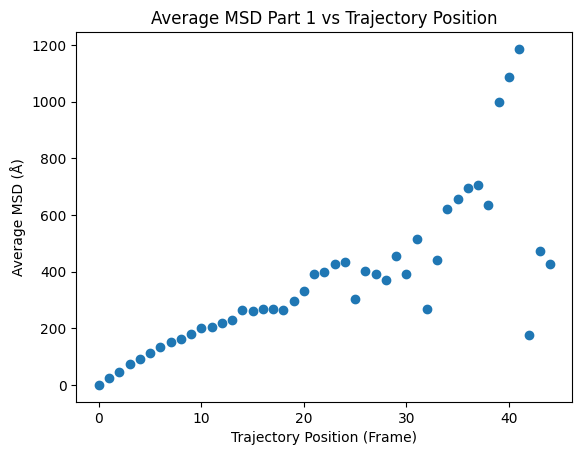

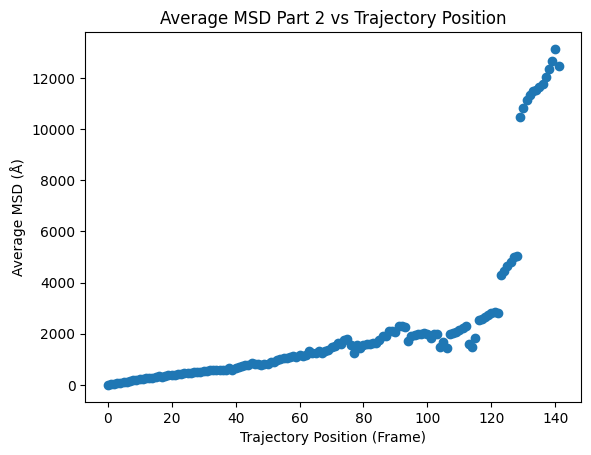

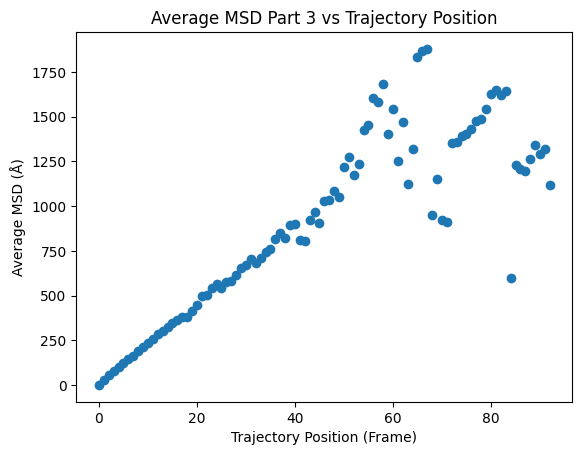

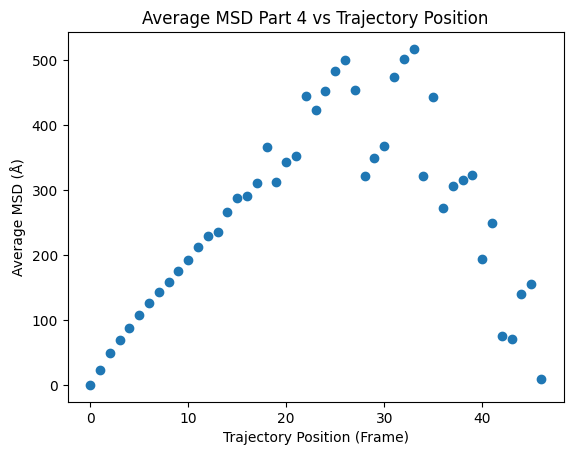

In [49]:
for part in final.keys():
    x_vals = range(0,len(final[part]))
    y_vals = final[part]

    plt.figure()
    plt.scatter(x_vals, y_vals)
    plt.xlabel('Trajectory Position (Frame)')
    plt.ylabel('Average MSD (Å)')
    plt.title(f'Average MSD Part {part} vs Trajectory Position')
    plt.plot()

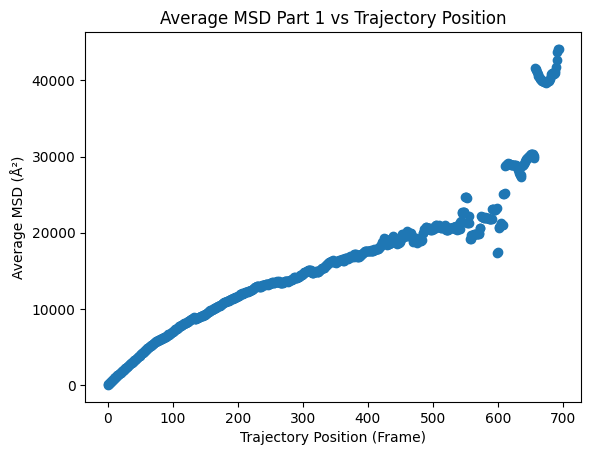

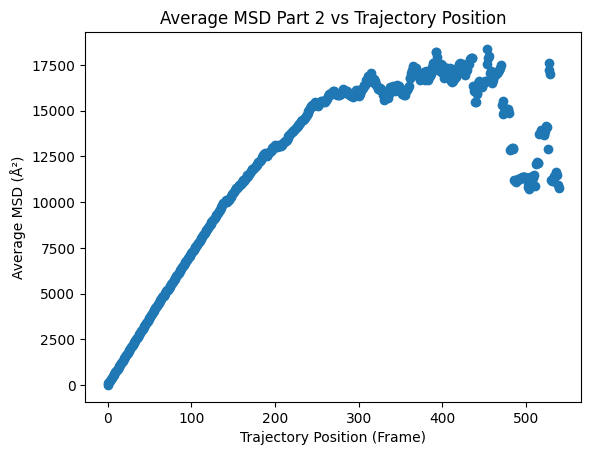

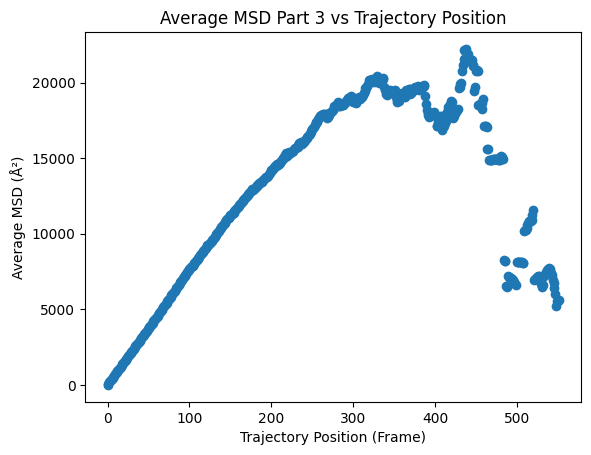

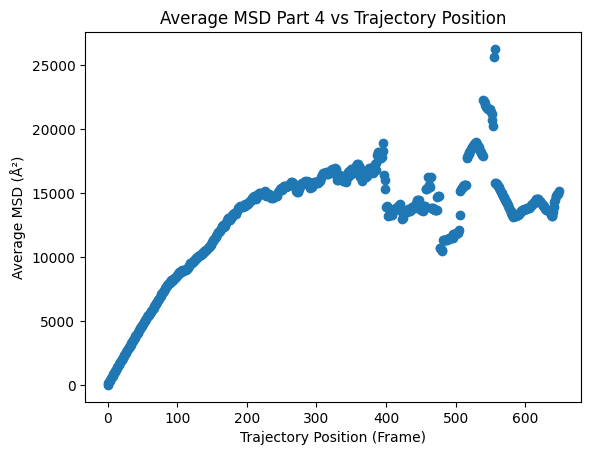

In [55]:
import os
import MDAnalysis as mda
import matplotlib.pyplot as plt
import numpy as np

# File paths
data_dir = r'D:\all_programming\MSD\data_files\unwrapped'
graphite_water_psf = os.path.join(data_dir, 'graphite_water.psf')
graphite_trajectory_dcd = os.path.join(data_dir, 'output_per_20ps.dcd')

# Load data
global_uni = mda.Universe(graphite_water_psf, graphite_trajectory_dcd)
Oxg_uni = global_uni.select_atoms('resname SPCE and name OW')

# Find max z values per frame
z_maxs = [max(atom[2] for atom in Oxg_uni.positions) for frame in global_uni.trajectory]

# Set parameters
upper_z_bound = 65
partition_count = 4
z_partitions = np.linspace(0, upper_z_bound, partition_count + 1)

def calculate_msd(position_dict):
    part_location = position_dict['location']
    x_vals = np.array(position_dict['x_vals'])
    y_vals = np.array(position_dict['y_vals'])
    z_vals = np.array(position_dict['z_vals'])

    num_points = len(x_vals)
    msd = np.zeros(num_points)
    
    for dt in range(1, num_points):
        displacements = (x_vals[dt:] - x_vals[:-dt])**2 + (y_vals[dt:] - y_vals[:-dt])**2 + (z_vals[dt:] - z_vals[:-dt])**2
        msd[dt] = np.mean(displacements)
    
    return [msd, part_location]

# Determine initial partition of each atom
atom_initial_part_list = []
for atom_num, pos in enumerate(Oxg_uni.positions):
    for i, bound in enumerate(z_partitions):
        if pos[2] < bound:
            atom_initial_part_list.append(i)
            break

# Track atom positions over frames
atom_dict = {atom_num: {'x_vals': [], 'y_vals': [], 'z_vals': []} for atom_num in range(len(Oxg_uni))}

for frame in global_uni.trajectory:
    Oxg_positions = Oxg_uni.positions
    for atom_num, (x, y, z) in enumerate(Oxg_positions):
        current_part = next((i for i, bound in enumerate(z_partitions) if z < bound), len(z_partitions) - 1)
        if current_part == atom_initial_part_list[atom_num]:
            atom_dict[atom_num]['location'] = current_part
            atom_dict[atom_num]['x_vals'].append(x)
            atom_dict[atom_num]['y_vals'].append(y)
            atom_dict[atom_num]['z_vals'].append(z)

# Calculate MSD for each atom
msd_dict = {atom_num: calculate_msd(atom_dict[atom_num]) for atom_num in atom_dict}

# Organize MSD by partition
msd_part_dict = {i: [] for i in range(1, len(z_partitions))}
for msd_data in msd_dict.values():
    msd_part_dict[msd_data[1]].append(msd_data[0])

def matrix_addition(array1, array2):
    if len(array1) > len(array2):
        array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
    else:
        array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
    return array1 + array2

msd_summed_dict = {key: np.zeros(1) for key in msd_part_dict}
for key, msd_arrays in msd_part_dict.items():
    for arr in msd_arrays:
        msd_summed_dict[key] = matrix_addition(msd_summed_dict[key], arr)

# Determine the maximum length of MSD arrays
max_length = max(len(arr) for arr_list in msd_part_dict.values() for arr in arr_list)

avg_val_dict = {key: {i: sum(len(arr) > i for arr in msd_part_dict[key]) for i in range(max_length)} for key in msd_part_dict}

def fill_missing_keys_in_subdicts(nested_dict):
    def fill_missing_keys(sub_dict):
        if not sub_dict:
            return {}
        sorted_keys = sorted(sub_dict)
        filled_dict = {key: sub_dict.get(key, None) for key in range(sorted_keys[0], sorted_keys[-1] + 1)}
        return filled_dict

    return {k: fill_missing_keys(v) for k, v in nested_dict.items()}

filled_nested_dict = fill_missing_keys_in_subdicts(avg_val_dict)

final = {part: [ele / filled_nested_dict[part][i] for i, ele in enumerate(msd_summed_dict[part])] for part in msd_summed_dict}

# Plot results
for part, y_vals in final.items():
    plt.figure()
    plt.scatter(range(len(y_vals)), y_vals)
    plt.xlabel('Trajectory Position (Frame)')
    plt.ylabel('Average MSD (Å²)')
    plt.title(f'Average MSD Part {part} vs Trajectory Position')
    plt.show()


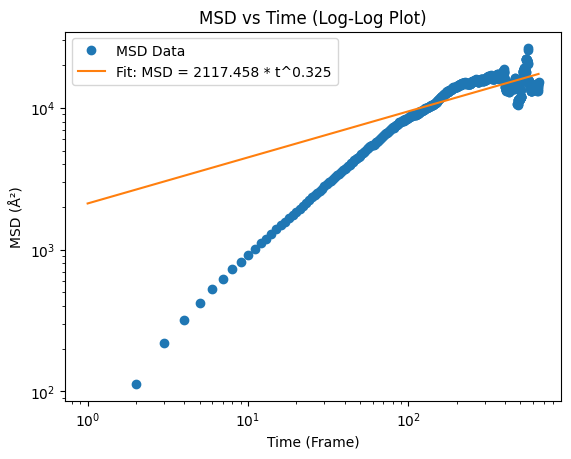

Fitted parameters: K = 2117.458, alpha = 0.325


In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Example MSD data (replace with your actual MSD data)
msd = np.array(final[4])  # Replace with your MSD data for a specific partition
time = np.arange(1, len(msd) + 1)  # Adjust time array length to match MSD length

# Define power law function
def power_law(t, K, alpha):
    return K * t**alpha

# Fit MSD data to power law
try:
    popt, pcov = curve_fit(power_law, time, msd, maxfev=10000)
    K, alpha = popt
except RuntimeError as e:
    print(f"Error during curve fitting: {e}")
    K, alpha = np.nan, np.nan

# Plot MSD data and power law fit
plt.figure()
plt.loglog(time, msd, 'o', label='MSD Data')
if not np.isnan(K) and not np.isnan(alpha):
    plt.loglog(time, power_law(time, *popt), '-', label=f'Fit: MSD = {K:.3f} * t^{alpha:.3f}')
plt.xlabel('Time (Frame)')
plt.ylabel('MSD (Å²)')
plt.legend()
plt.title('MSD vs Time (Log-Log Plot)')
plt.show()

print(f"Fitted parameters: K = {K:.3f}, alpha = {alpha:.3f}")


In [45]:
summed_dict = msd_summed_dict
avg_dict = filled_nested_dict

result_dict = {}

for key in summed_dict:
    result_dict[key] = []
    summed_values = summed_dict[key]
    avg_values = avg_dict[key]
    
    # Ensure the avg_dict items are sorted by their keys
    sorted_avg_values = dict(sorted(avg_values.items()))
    
    for index, avg_value in sorted_avg_values.items():
        if index - 1 < len(summed_values):
            result_dict[key].append(summed_values[index - 1] / avg_value)

print(result_dict)

{1: [0.9690719040980678, 0.0, 25.38207905388967, 53.9777319298473, 81.4587514311381, 104.60877603056863, 125.47601651540859, 149.59432239520524, 168.66251150459203, 184.9404285070757, 208.0370651554147, 226.68373188086773, 235.06318161779984, 253.24949831668295, 284.03106223950135, 294.19968308185514, 291.9067813651419, 300.5358095984535, 318.243344541563, 316.24605438402205, 327.9878767078832, 361.0790845267029, 402.1353686022598, 411.3365266906739, 455.48004845654, 502.4350138403565, 446.3974482033717, 455.8461294045977, 452.65678629235475, 436.13867561458574, 453.7810035842276, 539.2152738164004, 588.6790479578224, 468.1618590129765, 585.4977780143826, 620.1075889373275, 657.3488616682201, 695.764270556981, 705.574756210473, 954.5440467523076, 999.571528966993, 1087.4707174035839, 1185.6180336392376, 352.87582317635685, 473.30507017048706, 425.42256589905173], 2: [9.604208613932434, 0.0, 25.539204152677264, 51.80367756643998, 75.43153783166736, 98.27364981394804, 121.47702401263975,

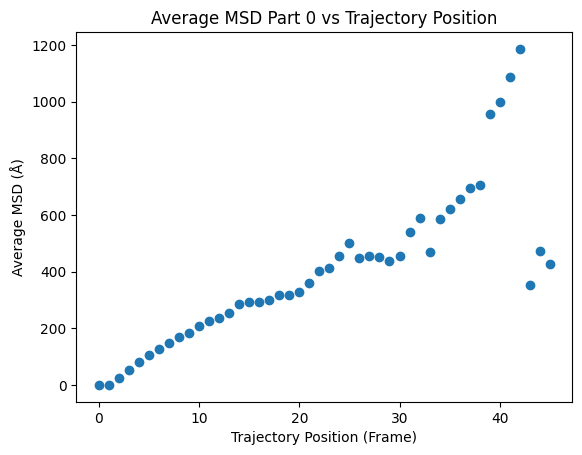

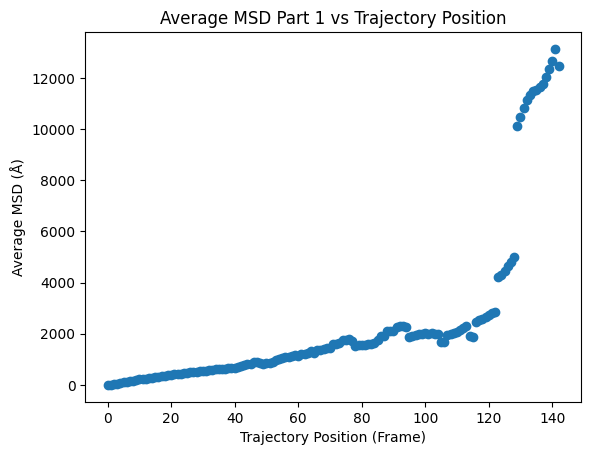

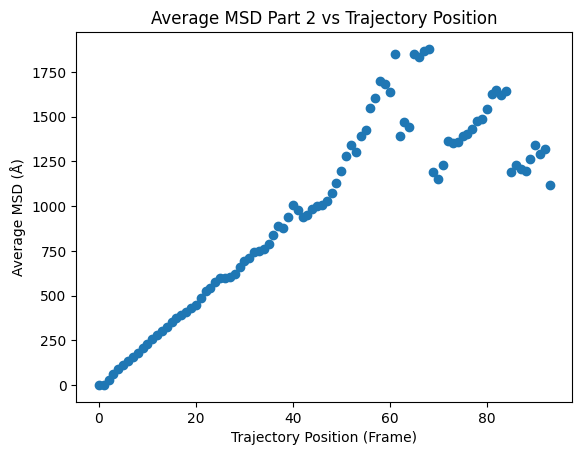

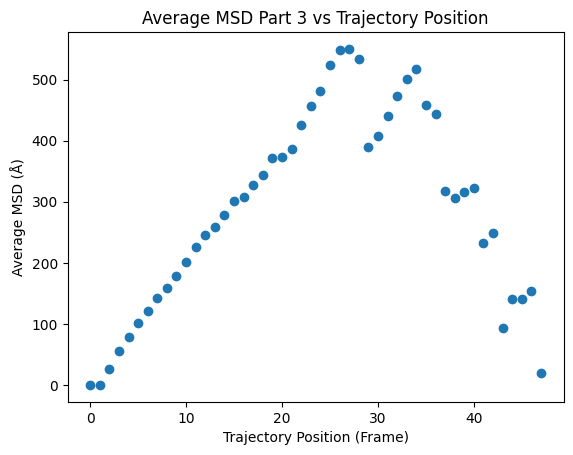

In [44]:
for i in range(len(result_dict.keys())):
    x_vals = range(0,len(result_dict[i + 1]))
    y_vals = result_dict[i + 1]

    plt.figure()
    plt.scatter(x_vals, y_vals)
    plt.xlabel('Trajectory Position (Frame)')
    plt.ylabel('Average MSD (Å)')
    plt.title(f'Average MSD Part {i} vs Trajectory Position')
    plt.plot()